<a href="https://colab.research.google.com/github/ShannonBonilla/COMM557_Project/blob/main/RQ2_TikTok_vs_Spotify_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Colab cwd recovery + fresh clone + sanity checks ---

import os, shutil, subprocess, sys

def safe_chdir(path):
    try:
        os.chdir(path)
    except Exception as e:
        print(f"[warn] chdir to {path} failed: {e}")

# 1) hard reset to a known-good location
safe_chdir("/")
safe_chdir("/content")
print("[info] cwd now:", os.getcwd())

REPO_URL = "https://github.com/ShannonBonilla/COMM557_Project.git"
REPO_DIR = "/content/COMM557_Project"

# 2) remove any half-broken clone
shutil.rmtree(REPO_DIR, ignore_errors=True)

# 3) fresh clone
print("[info] cloning repo...")
rc = subprocess.call(["git", "clone", REPO_URL, REPO_DIR])
if rc != 0:
    raise RuntimeError("git clone failed; check your internet or repo URL")

# 4) move into repo (now that it exists)
safe_chdir(REPO_DIR)
print("[info] in repo:", os.getcwd())

# 5) print quick tree
print("\n[info] top-level files:")
os.system("ls -lah | sed -n '1,80p'")

print("\n[info] data/ folder:")
os.system("ls -lah data | sed -n '1,120p'")

# 6) define paths for later cells
ROOT = REPO_DIR
DATA = os.path.join(REPO_DIR, "data")
print("\n[ok] ROOT:", ROOT)
print("[ok] DATA:", DATA)



[info] cwd now: /content
[info] cloning repo...
[info] in repo: /content/COMM557_Project

[info] top-level files:

[info] data/ folder:

[ok] ROOT: /content/COMM557_Project
[ok] DATA: /content/COMM557_Project/data


In [2]:
from pathlib import Path
import pandas as pd, numpy as np, re, unicodedata, ast, os

DATA = Path("data")

def norm_cols(df):
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

def safe_lower_ascii(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    return s.strip().lower()

def canon_title(raw: str) -> str:
    s = safe_lower_ascii(raw)
    s = re.sub(r"\s*\((feat[^)]*)\)", "", s)
    s = re.sub(r"\s*-\s*(remaster(?:ed)?(?:\s*\d{2,4})?|radio edit|single version|album version|clean|explicit|live|bonus track)\s*$","", s)
    s = s.replace("&", " and ")
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if not s:
        s = safe_lower_ascii(raw)
        s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_artist_field(raw) -> list[str]:
    if raw is None or (isinstance(raw, float) and pd.isna(raw)): return []
    text = str(raw).strip()
    if text.startswith("[") and text.endswith("]"):
        try:
            vals = ast.literal_eval(text)
            if isinstance(vals,(list,tuple)):
                return [str(v).strip() for v in vals if str(v).strip()]
        except Exception:
            pass
    t = safe_lower_ascii(text)
    t = re.sub(r"\s+feat\.?\s+"," , ", t)
    t = re.sub(r"\s+featuring\s+"," , ", t)
    t = re.sub(r"\s+with\s+"," , ", t)
    t = re.sub(r"\s+and\s+"," , ", t)
    t = re.sub(r"\s*&\s*"," , ", t)
    t = re.sub(r"\s+x\s+"," , ", t)
    t = t.replace("/", " , ").replace(";", " , ")
    parts = [p.strip() for p in t.split(",") if p.strip()]
    return parts if parts else ([t] if t else [])

def canon_artist(raw: str) -> str:
    names = parse_artist_field(raw)
    primary = names[0] if names else ""
    primary = re.sub(r"[^a-z0-9\s]+"," ", primary)
    primary = re.sub(r"\s+"," ", primary).strip()
    return primary

def add_key_with_canon(df: pd.DataFrame, title_col="title", artist_col="artist") -> pd.DataFrame:
    if title_col not in df.columns or artist_col not in df.columns:
        raise ValueError("Need title/artist columns to build canonical keys.")
    df["title_canon"]  = df[title_col].map(canon_title)
    df["artist_canon"] = df[artist_col].map(canon_artist)
    df["key_canon"]    = df["title_canon"] + " // " + df["artist_canon"]
    bad = (df["title_canon"] == "") | (df["artist_canon"] == "")
    if bad.any(): df = df.loc[~bad].copy()
    return df


In [3]:
# --- Step 2 (robust): build TikTok/Spotify membership with per-file column detection ---
from pathlib import Path
import pandas as pd, os, re, unicodedata, ast

DATA = Path("data")

# File lists
tiktok_files  = sorted([f for f in os.listdir(DATA) if re.match(r"(?i)TikTok_songs_\d{4}\.csv", f)])
spotify_files = sorted([f for f in os.listdir(DATA) if re.match(r"(?i)spotify_top_charts_\d{2}\.csv", f)])

# ----- utilities you already defined earlier -----
def norm_cols(df):
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

def safe_lower_ascii(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    return s.strip().lower()

def canon_title(raw: str) -> str:
    s = safe_lower_ascii(raw)
    s = re.sub(r"\s*\((feat[^)]*)\)", "", s)
    s = re.sub(r"\s*-\s*(remaster(?:ed)?(?:\s*\d{2,4})?|radio edit|single version|album version|clean|explicit|live|bonus track)\s*$", "", s)
    s = s.replace("&", " and ")
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if not s:
        s = safe_lower_ascii(raw)
        s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_artist_field(raw) -> list[str]:
    if raw is None or (isinstance(raw, float) and pd.isna(raw)): return []
    text = str(raw).strip()
    if text.startswith("[") and text.endswith("]"):
        try:
            vals = ast.literal_eval(text)
            if isinstance(vals,(list,tuple)):
                return [str(v).strip() for v in vals if str(v).strip()]
        except Exception:
            pass
    t = safe_lower_ascii(text)
    t = re.sub(r"\s+feat\.?\s+"," , ", t)
    t = re.sub(r"\s+featuring\s+"," , ", t)
    t = re.sub(r"\s+with\s+"," , ", t)
    t = re.sub(r"\s+and\s+"," , ", t)
    t = re.sub(r"\s*&\s*"," , ", t)
    t = re.sub(r"\s+x\s+"," , ", t)
    t = t.replace("/", " , ").replace(";", " , ")
    parts = [p.strip() for p in t.split(",") if p.strip()]
    return parts if parts else ([t] if t else [])

def canon_artist(raw: str) -> str:
    names = parse_artist_field(raw)
    primary = names[0] if names else ""
    primary = re.sub(r"[^a-z0-9\s]+"," ", primary)
    primary = re.sub(r"\s+"," ", primary).strip()
    return primary

def add_key_with_canon(df: pd.DataFrame, title_col="title", artist_col="artist") -> pd.DataFrame:
    if title_col not in df.columns or artist_col not in df.columns:
        raise ValueError("Need title/artist columns to build canonical keys.")
    df["title_canon"]  = df[title_col].map(canon_title)
    df["artist_canon"] = df[artist_col].map(canon_artist)
    df["key_canon"]    = df["title_canon"] + " // " + df["artist_canon"]
    bad = (df["title_canon"] == "") | (df["artist_canon"] == "")
    if bad.any(): df = df.loc[~bad].copy()
    return df

# ----- NEW: per-file column detector with smart fallbacks -----
TITLE_CANDS  = {"title","track","track_name","track_title","song","song_title","name"}
ARTIST_CANDS = {"artist","artists","artist_name","artist_names","primary_artist","performer","singer","band"}

def detect_title_artist_cols(df: pd.DataFrame, file_label: str):
    """
    Returns (title_col, artist_col). Tries:
      1) direct matches from TITLE_CANDS / ARTIST_CANDS
      2) suffix matches (e.g., '*track_name', '*artist_name')
      3) parse from a single text column 'Title - Artist' or 'Title by Artist'
      4) Spotify-style combined columns like 'track__artists' -> split list
    Raises ValueError with diagnostics if still not found.
    """
    df = norm_cols(df.copy())
    cols = list(df.columns)

    # direct
    title_col  = next((c for c in cols if c in TITLE_CANDS), None)
    artist_col = next((c for c in cols if c in ARTIST_CANDS), None)

    # suffix/prefixed variants
    if title_col is None:
        title_col = next((c for c in cols if c.endswith("track_name") or c.endswith("track") or c.endswith("song") or c.endswith("title")), None)
    if artist_col is None:
        artist_col = next((c for c in cols if c.endswith("artist_name") or c.endswith("artists") or c.endswith("artist")), None)

    # spotify export quirks (sometimes nested names)
    if artist_col is None:
        artist_col = next((c for c in cols if "artist" in c), None)
    if title_col is None:
        title_col = next((c for c in cols if "track" in c or "song" in c or "title" in c), None)

    # parse from single long text col
    def try_parse(series: pd.Series):
        s = series.astype(str)
        if s.str.contains(" - ").any():
            parts = s.str.split(" - ", n=1, expand=True)
            if parts.shape[1] == 2: return parts[0], parts[1]
        if s.str.contains(r"\s+by\s+", regex=True).any():
            parts = s.str.split(r"\s+by\s+", n=1, expand=True, regex=True)
            if parts.shape[1] == 2: return parts[0], parts[1]
        return None, None

    parsed_cols = False
    if title_col is None or artist_col is None:
        text_cols = [c for c in cols if df[c].dtype == object]
        for c in text_cols:
            if df[c].notna().any():
                t_guess, a_guess = try_parse(df[c].dropna())
                if t_guess is not None:
                    df["__title_guess"]  = t_guess
                    df["__artist_guess"] = a_guess
                    title_col, artist_col = "__title_guess", "__artist_guess"
                    parsed_cols = True
                    break

    if title_col is None or artist_col is None:
        raise ValueError(f"[diag] Could not map title/artist for {file_label}. Columns: {cols}")

    # If artist column looks like a list, leave it—we handle in canon_artist()
    return df, title_col, artist_col

def build_keys(files, label):
    keys, dropped_total = set(), 0
    for fname in files:
        p = DATA / fname
        df_raw = pd.read_csv(p)
        df_map, tcol, acol = detect_title_artist_cols(df_raw, f"{label}:{fname}")
        before = len(df_map)
        df2 = add_key_with_canon(df_map, tcol, acol)
        dropped_total += (before - len(df2))
        keys |= set(df2["key_canon"])
    if dropped_total:
        print(f"[{label}] Dropped {dropped_total} rows with empty title/artist after cleaning.")
    return keys

# ---- Build sets now
tik_keys = build_keys(tiktok_files, "TikTok")
sp_keys  = build_keys(spotify_files, "Spotify")

TIKTOK_CROSSOVER = frozenset(sp_keys & tik_keys)
SPOTIFY_ONLY     = frozenset(sp_keys - tik_keys)

print("TikTok files:", tiktok_files)
print("Spotify files:", spotify_files)
print(f"Counts -> TikTok set: {len(tik_keys)} | Spotify set: {len(sp_keys)}")
print(f"Groups -> Crossover: {len(TIKTOK_CROSSOVER)} | Spotify-only: {len(SPOTIFY_ONLY)}")
print("Sample Spotify-only:", list(sorted(SPOTIFY_ONLY))[:10])



[TikTok] Dropped 4 rows with empty title/artist after cleaning.
TikTok files: ['TikTok_songs_2019.csv', 'TikTok_songs_2020.csv', 'TikTok_songs_2021.csv', 'TikTok_songs_2022.csv']
Spotify files: ['spotify_top_charts_19.csv', 'spotify_top_charts_20.csv', 'spotify_top_charts_21.csv', 'spotify_top_charts_22.csv']
Counts -> TikTok set: 811 | Spotify set: 3071
Groups -> Crossover: 260 | Spotify-only: 2811
Sample Spotify-only: ['! // trippie redd', '00 00 zero oclock // bts', '0x1 lovesong i know i love you feat seori // tomorrow', '1 0 0 m i l with bas // j cole', '1 step forward 3 steps back // olivia rodrigo', '10 000 hours with justin bieber // dan shay', '10 freaky girls with 21 savage // metro boomin', '10 things i hate about you // leah kate', '10 years // dai freyr', '1000 doves // lady gaga']


In [4]:
# Replace with your exact repo path if different
%cd /content/COMM557_Project

# Download the CSV from GitHub raw into your data/ folder (overwrites if present)
!curl -L -o data/dataset_with_topics.csv \
  "https://raw.githubusercontent.com/ShannonBonilla/COMM557_Project/refs/heads/main/data/dataset_with_topics.csv"


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7933k  100 7933k    0     0  16.6M      0 --:--:-- --:--:-- --:--:-- 16.6M


In [5]:
import pandas as pd

topics_path = "/content/COMM557_Project/data/dataset_with_topics.csv"
df = pd.read_csv(topics_path)
print(df.shape)
print(df.columns[:15].tolist())
df.head(2)





(3357, 19)
['track_name', 'artist_name', 'danceability', 'energy', 'loudness', 'mode', 'key', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'time_signature', 'duration_ms', 'source']


,track_name,artist_name,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms,source,lyrics,lyrics_missing,topic_number,topic_label
0,Wow.,Post Malone,833.0,539.0,"-7,399",0,11,178.0000,163.00,0.000002,101.0,"99,947",4,149520,spotify,"Said she tired of little money, need a big boy...",False,2.0,Boastful Rap Themes
1,"thank u, next",Ariana Grande,724.0,647.0,"-5,642",1,1,0.0658,0.28,0.000000,102.0,106.96,4,207333,spotify,Thought I'd end up with Sean\nBut he wasn't a ...,False,0.0,Love & Life Themes


In [6]:
# --- Step 3: use topic_number/topic_label (no probs needed) ---

import pandas as pd, numpy as np, re, unicodedata, ast

topics_path = "/content/COMM557_Project/data/dataset_with_topics.csv"

def norm_cols(df):
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

def safe_lower_ascii(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    return s.strip().lower()

def canon_title(raw: str) -> str:
    s = safe_lower_ascii(raw)
    s = re.sub(r"\s*\((feat[^)]*)\)", "", s)
    s = re.sub(r"\s*-\s*(remaster(?:ed)?(?:\s*\d{2,4})?|radio edit|single version|album version|clean|explicit|live|bonus track)\s*$","", s)
    s = s.replace("&", " and ")
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s or re.sub(r"\s+"," ", safe_lower_ascii(raw)).strip()

def parse_artist_field(raw):
    if raw is None or (isinstance(raw, float) and pd.isna(raw)): return []
    text = str(raw).strip()
    if text.startswith("[") and text.endswith("]"):
        try:
            vals = ast.literal_eval(text)
            if isinstance(vals,(list,tuple)):
                return [str(v).strip() for v in vals if str(v).strip()]
        except: pass
    t = safe_lower_ascii(text)
    for pat in [r"\s+feat\.?\s+", r"\s+featuring\s+", r"\s+with\s+", r"\s+and\s+", r"\s*&\s*", r"\s+x\s+"]:
        t = re.sub(pat, " , ", t)
    t = t.replace("/", " , ").replace(";", " , ")
    parts = [p.strip() for p in t.split(",") if p.strip()]
    return parts if parts else ([t] if t else [])

def canon_artist(raw):
    names = parse_artist_field(raw); primary = names[0] if names else ""
    primary = re.sub(r"[^a-z0-9\s]+", " ", primary); primary = re.sub(r"\s+"," ", primary).strip()
    return primary

def add_key_canon_from_cols(df, tcol, acol):
    df["title_canon"]  = df[tcol].map(canon_title)
    df["artist_canon"] = df[acol].map(canon_artist)
    df["key"]          = df["title_canon"] + " // " + df["artist_canon"]
    bad = (df["title_canon"] == "") | (df["artist_canon"] == "")
    return df.loc[~bad].copy()

# load & normalize
topics = pd.read_csv(topics_path)
topics = norm_cols(topics)

# choose topic column: prefer topic_number; fallback to label digits
if "topic_number" in topics.columns:
    topics["topic"] = pd.to_numeric(topics["topic_number"], errors="coerce").astype("Int64")
elif "topic_label" in topics.columns:
    s = topics["topic_label"].astype(str).str.extract(r"(\d+)").squeeze()
    topics["topic"] = pd.to_numeric(s, errors="coerce").astype("Int64")
else:
    raise ValueError("No 'topic_number' or 'topic_label' column found in topics file.")

# standardize title/artist -> canonical key
tcol = "track_name" if "track_name" in topics.columns else "title"
acol = "artist_name" if "artist_name" in topics.columns else "artist"
if tcol not in topics.columns or acol not in topics.columns:
    raise ValueError("Expected 'track_name'/'artist_name' (or 'title'/'artist') in topics file.")
topics = add_key_canon_from_cols(topics, tcol, acol)

# keep one row per key and valid topic
topics = topics.dropna(subset=["topic"]).copy()
topics["topic"] = topics["topic"].astype(int)
topics = topics.drop_duplicates(subset=["key"], keep="first").copy()

print("topics columns:", topics.columns.tolist()[:15], "...")
print(f"[summary] topics={len(topics):,} | unique topics={topics['topic'].nunique()}")
print("Topic counts:", topics["topic"].value_counts().sort_index().to_dict())


topics columns: ['track_name', 'artist_name', 'danceability', 'energy', 'loudness', 'mode', 'key', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'time_signature', 'duration_ms', 'source'] ...
[summary] topics=3,256 | unique topics=20
Topic counts: {-1: 14, 0: 1124, 1: 702, 2: 307, 3: 375, 4: 344, 5: 70, 6: 62, 7: 62, 8: 34, 9: 20, 10: 22, 11: 12, 12: 21, 13: 16, 14: 13, 15: 28, 16: 16, 17: 8, 18: 6}


In [7]:
# assuming you already have: topics (with 'key' + 'topic'),
# and sets TIKTOK_CROSSOVER / SPOTIFY_ONLY from step 2

topic_keys = set(topics['key'])

cov_crossover = len(TIKTOK_CROSSOVER & topic_keys) / max(1, len(TIKTOK_CROSSOVER))
cov_spotify   = len(SPOTIFY_ONLY & topic_keys)     / max(1, len(SPOTIFY_ONLY))

print(f"Coverage — TikTok-Crossover: {cov_crossover:.1%}  |  Spotify-only: {cov_spotify:.1%}")

missing_crossover = list((TIKTOK_CROSSOVER - topic_keys))[:10]
missing_spotify   = list((SPOTIFY_ONLY   - topic_keys))[:10]
print("\nSample missing crossover keys:", missing_crossover)
print("Sample missing spotify-only keys:", missing_spotify)


Coverage — TikTok-Crossover: 93.8%  |  Spotify-only: 91.1%

Sample missing crossover keys: ['i don t care with justin bieber // ed sheeran', 'only the young featured in miss americana // taylor swift', 'trollz with nicki minaj // 6ix9ine', 'banana dj fle minisiren remix // conkarah', 'all the stars with sza // kendrick lamar', 'better days neiked x mae muller x polo g // neiked', 'sg with ozuna megan thee stallion and lisa of blackpink // dj snake', 'enemy with jid from the series arcane league of legends // imagine dragons', 'cooped up with roddy ricch // post malone', 'stay with justin bieber // the kid laroi']
Sample missing spotify-only keys: ['under the sun with j cole and lute feat dababy // dreamville', 'que calor // major lazer', 'after last night with thundercat and bootsy collins // bruno mars', 'entre nosotros remix con nicki nicole // tiago pzk', 'mistletoe and holly // frank sinatra', 'save your tears remix with ariana grande // the weeknd', 'hate me with juice wrld // ell

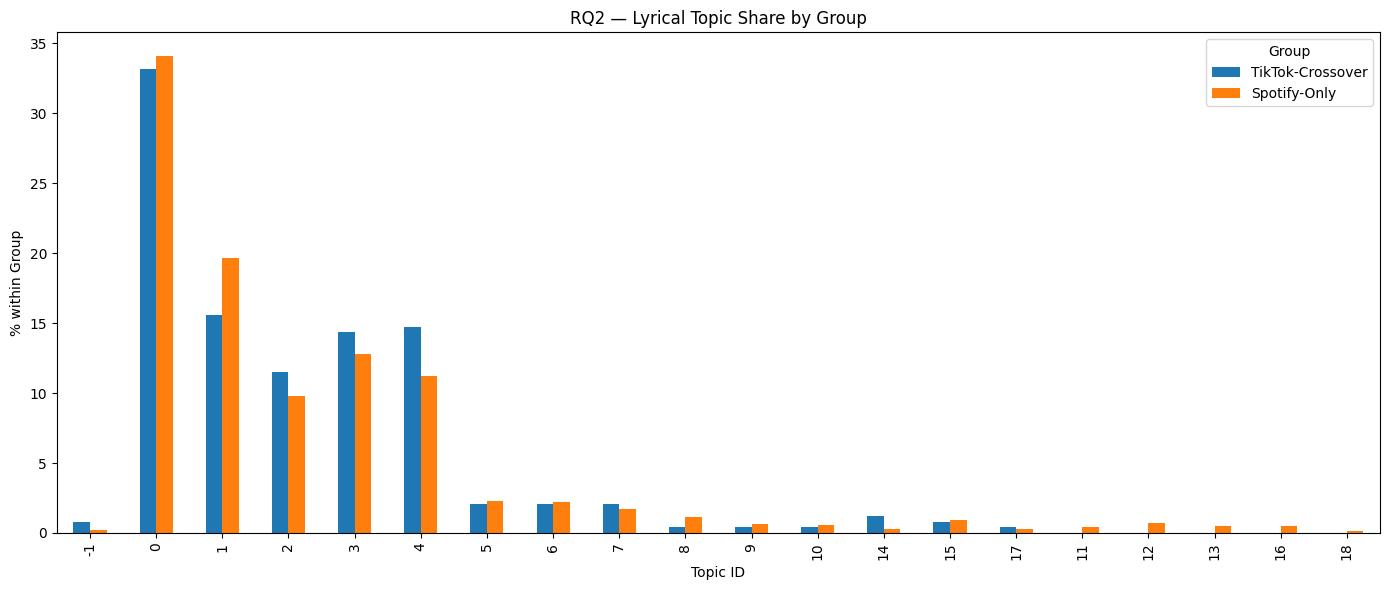

Saved to outputs/rq2_topics_bar_colab.png


In [8]:
# 1) one topic per key
topic_assign = topics.drop_duplicates(subset=["key"], keep="first")[["key","topic"]].copy()

# 2) shares per group
def topic_shares(keys_set, label):
    sub = topic_assign[topic_assign["key"].isin(keys_set)]
    s = (sub["topic"].value_counts(normalize=True) * 100).sort_index()
    return s.rename(label)

tik_s = topic_shares(TIKTOK_CROSSOVER, "TikTok-Crossover")
spo_s = topic_shares(SPOTIFY_ONLY,     "Spotify-Only")

# 3) combine + plot
plot_df = pd.concat([tik_s, spo_s], axis=1).fillna(0.0)
ax = plot_df.plot(kind="bar", figsize=(14,6))
ax.set_title("RQ2 — Lyrical Topic Share by Group")
ax.set_xlabel("Topic ID"); ax.set_ylabel("% within Group")
ax.legend(title="Group")
import os; os.makedirs("outputs", exist_ok=True)
import matplotlib.pyplot as plt
plt.tight_layout(); plt.savefig("outputs/rq2_topics_bar_colab.png", dpi=200); plt.show()

print("Saved to outputs/rq2_topics_bar_colab.png")


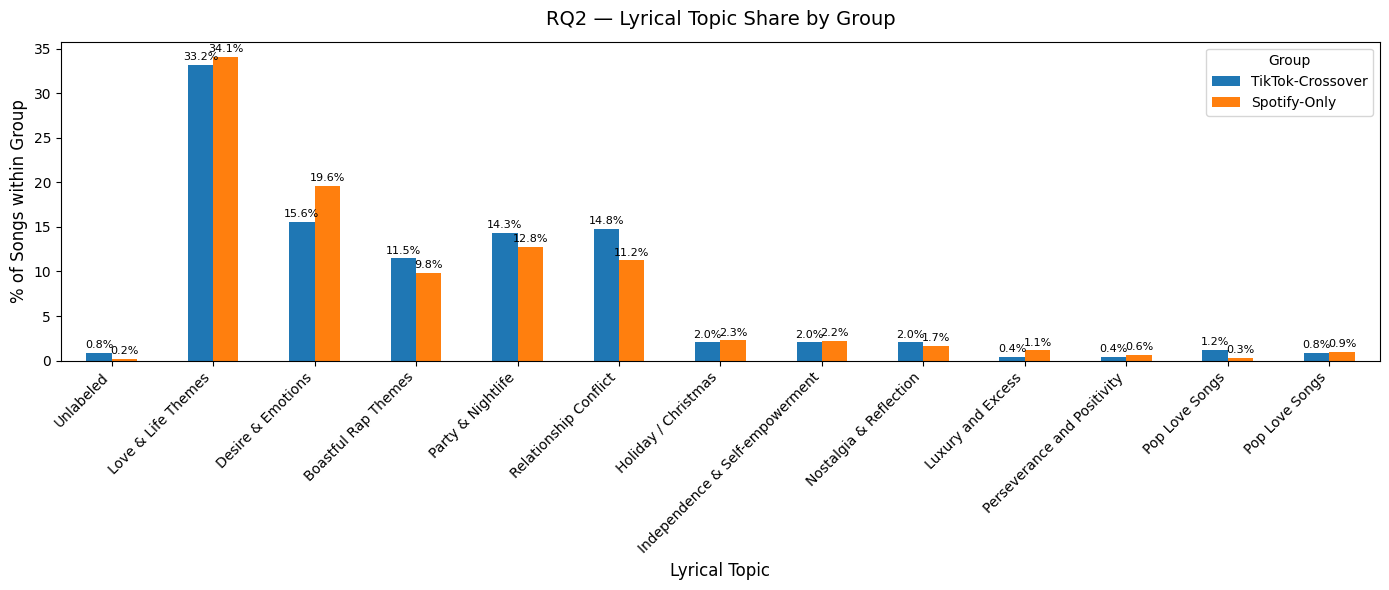

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Merge in readable labels
label_map = topics.drop_duplicates("topic")[["topic", "topic_label"]].set_index("topic")["topic_label"].to_dict()
plot_df.index = plot_df.index.map(label_map)

# Filter out extremely rare topics (<1%)
plot_df = plot_df.loc[(plot_df.sum(axis=1) >= 1)]

# Plot
ax = plot_df.plot(kind="bar", figsize=(14,6))
ax.set_title("RQ2 — Lyrical Topic Share by Group", fontsize=14, pad=12)
ax.set_xlabel("Lyrical Topic", fontsize=12)
ax.set_ylabel("% of Songs within Group", fontsize=12)
ax.legend(title="Group")

# Add percentage labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=2, fontsize=8)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
os.makedirs("outputs", exist_ok=True)
plt.savefig("outputs/rq2_topics_bar_labels.png", dpi=250)
plt.show()


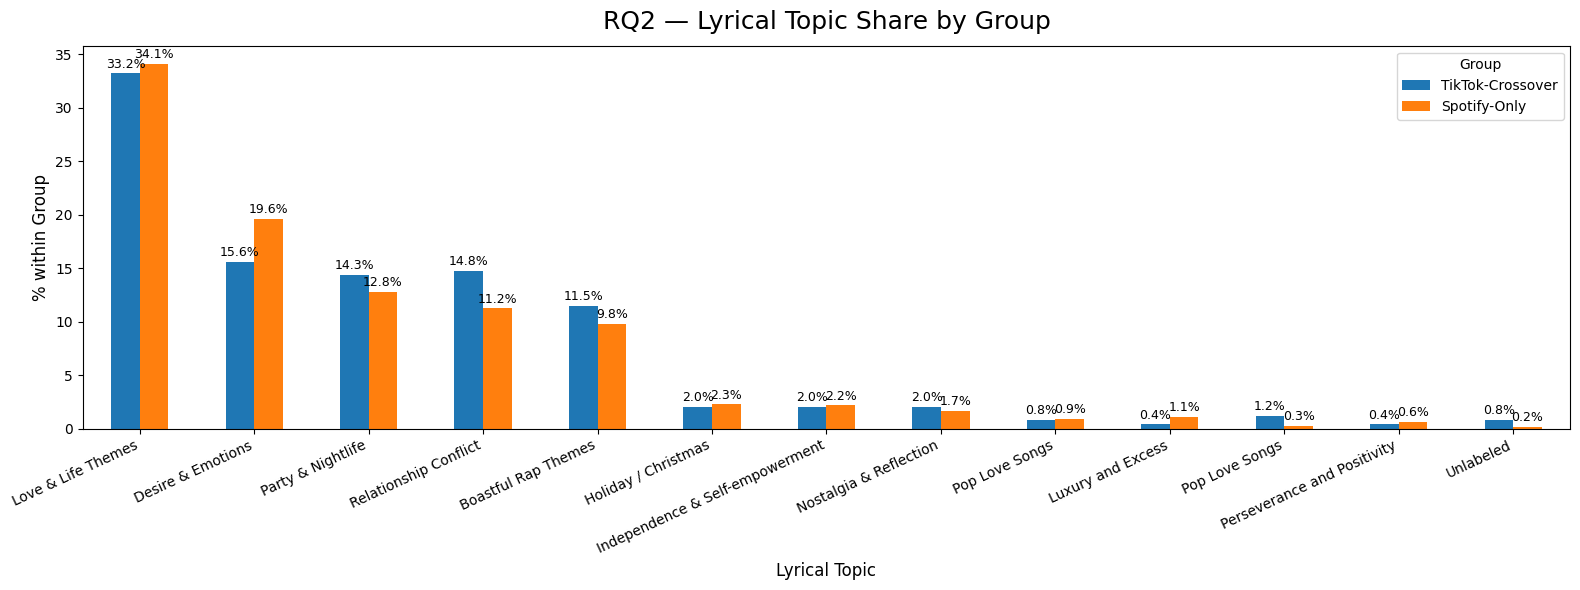

✅ Saved figure → outputs/rq2_topics_bar_labels.png


In [14]:
# === Final RQ2 Plot (Fuzzy Version - Fixed Variable) ===
# Requirements:
#   - topics DataFrame with ['key','topic','topic_label']
#   - TIKTOK_CROSSOVER = fuzzy crossover set
#   - SPOTIFY_ONLY = Spotify-only set

import pandas as pd, numpy as np, matplotlib.pyplot as plt, os

topic_assign = topics.drop_duplicates(subset=["key"], keep="first")[["key","topic","topic_label"]].copy()

def topic_shares(keys_set, label):
    sub = topic_assign[topic_assign["key"].isin(keys_set)]
    s   = (sub["topic"].value_counts(normalize=True) * 100.0).sort_index()
    return s.rename(label)

tik_s = topic_shares(TIKTOK_CROSSOVER, "TikTok-Crossover")
spo_s = topic_shares(SPOTIFY_ONLY, "Spotify-Only")  # ✅ fixed variable name

plot_df = pd.concat([tik_s, spo_s], axis=1).fillna(0.0)

# Map numeric topic IDs → readable labels
label_map = (topic_assign.drop_duplicates("topic")[["topic","topic_label"]]
                        .set_index("topic")["topic_label"].to_dict())
plot_df.index = plot_df.index.map(label_map)

# Filter & sort
plot_df["__total__"] = plot_df.sum(axis=1)
plot_df = plot_df.loc[plot_df["__total__"] >= 1.0].sort_values("__total__", ascending=False).drop(columns="__total__")

# Plot
fig, ax = plt.subplots(figsize=(16,6))
plot_df.plot(kind="bar", ax=ax)

ax.set_title("RQ2 — Lyrical Topic Share by Group", fontsize=18, pad=12)
ax.set_xlabel("Lyrical Topic", fontsize=12)
ax.set_ylabel("% within Group", fontsize=12)
ax.legend(title="Group")

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=2, fontsize=9)

plt.xticks(rotation=25, ha="right")
plt.tight_layout()

os.makedirs("outputs", exist_ok=True)
out_path = "outputs/rq2_topics_bar_labels.png"
plt.savefig(out_path, dpi=300)
plt.show()

print(f"✅ Saved figure → {out_path}")




In [16]:
# === Caption and Quick Summary ===

print("Figure: RQ2 — Lyrical Topic Share by Group")
print("Caption: Distribution of lyrical topics among TikTok-Crossover and Spotify-Only songs.")
print("Both groups exhibit similar topic patterns dominated by Love & Life and Desire & Emotions,")
print("indicating that lyrical content does not strongly distinguish viral songs from those achieving")
print("traditional streaming success.")

print(f"\nCounts → TikTok-Crossover: {len(TIKTOK_CROSSOVER):,} | Spotify-Only: {len(SPOTIFY_ONLY):,}")
print("Source file: rq2_topics_bar_fuzzy_labels.csv")


Figure: RQ2 — Lyrical Topic Share by Group
Caption: Distribution of lyrical topics among TikTok-Crossover and Spotify-Only songs.
Both groups exhibit similar topic patterns dominated by Love & Life and Desire & Emotions,
indicating that lyrical content does not strongly distinguish viral songs from those achieving
traditional streaming success.

Counts → TikTok-Crossover: 260 | Spotify-Only: 2,811
Source file: rq2_topics_bar_fuzzy_labels.csv
